# Tutorial 04 - Loading and printing surface positions in world camera coordinate space

In this tutorial we will look at how to load surface position data that was exported from Pupil Player in order to get positions of surfaces in pixels. We will follow these steps:

1. Load the data using `Pandas`
2. Transform and map surface vertices into world camera pixel coordinates 
3. Visualize the surfaces in world camera pixel space

## 1 - Loading Exported Surface Data

Now lets see how to load the exported surface position data for a single surface. The file will be named with the pattern `srf_positions_<your-surface-name>_<uid>.csv`. 

In [1]:
import os
import pandas as pd
import numpy as np

# the matrix in the csv file does not have commas to separate values
# we need to do a bit of formatting with our parse function
# so that we will be able to read the matrix in python as numeric and not strings
def parse(filedata):
    output = []
    for line in filedata.split('\n'):
        line = line.strip().rstrip(']').lstrip('[')
        if not line:
            continue
        line = line.split()
        row = []
        for cell in line:
            cell = cell.strip()
            if not cell.strip():
                continue
            row.append(float(cell))
        output.append(row)
    return output

recordings_location = '/home/pupil-labs/recordings'
demo_recording = '2019_02_15/000'
file_name = 'srf_positons_magazine_cover_1550027153.7953088.csv'
exported_surface_csv = os.path.join(recordings_location, demo_recording, 
                                    'exports', '000', 'surfaces', file_name)
surface_pd_frame = pd.read_csv(exported_surface_csv, 
                               converters={'m_to_screen': parse, 'm_from_screen': parse})

print("Columns present in exported surface positions data file:\n {}".format(surface_pd_frame.columns))

Columns present in exported surface positions data file:
 Index(['frame_idx', 'timestamp', 'm_to_screen', 'm_from_screen',
       'detected_markers'],
      dtype='object')


### Individual Datums

As we can see the data frame contains only a few columns. Let's review what each column is used for:

- `frame_idx` - The frame number of the world camera to which this sample is correlated.
- `timestamp` - The world camera timestamp at which the sample was recorded.
- `m_to_screen` - 3x3 transformation matrix from reference surface coordinate space to screen coordinate space.
- `m_from_screen` - 3x3 transformation matrix from screen coordinate space to reference surface coordinate space.
- `detected_markers` - number of markers that were detected for this datum.

Let's take a look at a few values!


In [2]:
gaze_on_srf = surface_pd_frame
pd.options.display.float_format = '{:.3f}'.format

headers = surface_pd_frame.columns
print("surface positions for (magazine surface):\n {}".format(gaze_on_srf[headers][:5]))

surface positions for (magazine surface):
    frame_idx  timestamp                                        m_to_screen  \
0          0 346699.983  [[0.22312064, -0.02384371, 0.41324005], [-0.03...   
1          1 346700.016  [[0.22128125, -0.02224182, 0.41344452], [-0.03...   
2          2 346700.050  [[0.22064407, -0.01922338, 0.41348585], [-0.03...   
3          3 346700.066  [[0.2186187, -0.01681549, 0.41348475], [-0.037...   
4          4 346700.083  [[0.22020477, -0.01681111, 0.41327593], [-0.03...   

                                       m_from_screen  detected_markers  
0  [[4.64725956, -0.1165445, -1.90203712], [0.328...                 2  
1  [[4.67909834, -0.11823523, -1.91586249], [0.33...                 2  
2  [[4.68001328, -0.12789828, -1.91489377], [0.32...                 2  
3  [[4.7119878, -0.12937643, -1.92785237], [0.334...                 2  
4  [[4.67711897, -0.12870151, -1.91252995], [0.32...                 2  


## 2 - Transform and map surface vertices into world camera pixel coordinates

Use each transformation matrix to get the "distorted" corner coordinates of the surface. The surface corners are always `((0,0), (0,1), (1,1), (1,0))`. We use OpenCV's `perspectiveTransform` method for matrix multiplication, where we supply a point and transform it with our matrix. The result is the position of the corner in the distorted space of the world camera. Then we must denormalize the coordinate to map it from 0 to 1 range into the pixel space of the world camera.

In [3]:
import cv2
import re

def denormalize(pos, width, height, flip_y=False):
    x = pos[0]
    y = pos[1]
    x *= width
    if flip_y:
        y = 1-y
    y *= height
    return x,y

def transform_surface_corners(pos, m_to_screen):
    shape = pos.shape
    pos.shape = (-1,1,2)
    new_pos = cv2.perspectiveTransform(pos, m_to_screen )
    new_pos.shape = shape
    return new_pos

m_to_screen = surface_pd_frame['m_to_screen']
corners = [[0.,0.],[0.,1.],[1.,1.],[1.,0.]]

# use the transformation matrix to map the corners of the surface to pixel space
# 1. transform corners with perspective transformation using the matrix
# 2. denormalize the coordinates to that we mapped to the scale of the screen
surface_screen_corners = []
for matrix in m_to_screen:
    denormalized_corner_positions = []
    for c in corners:
        surface_corners_screen = denormalize(transform_surface_corners(np.array(c), np.asarray(matrix)), 
                                                width = 1280, height = 720)
        denormalized_corner_positions.append(surface_corners_screen)
    surface_screen_corners.append(denormalized_corner_positions)


# add corners of the surface in screen coordinates back to the pandas dataframe for convenience
surface_pd_frame = surface_pd_frame.assign(surface_position_screen=pd.Series(surface_screen_corners))

# confirm that the corners of the surface mapped to pixel space are in the data frame
print(surface_pd_frame['surface_position_screen'][:5])

0    [(528.947264, 113.65253279999999), (546.455700...
1    [(529.2089856, 113.78378880000001), (546.77166...
2    [(529.261888, 113.8590504), (548.180155821668,...
3    [(529.26048, 113.9896368), (548.1789317319905,...
4    [(528.9931904, 114.1845768), (547.950819943841...
Name: surface_position_screen, dtype: object


## 3. Visualize the surfaces in world camera pixel space

We will simply plot the instances of this surface - `magazine_cover` - within this recording using matplot lib. The plot size is equal to the world camera frame `1280 pixels x 720 pixels`. 

You can see from the plot below that the surface/participant did not move much through out the duration of the recording. Hence, we have many overlapping rectangles for each surface. 

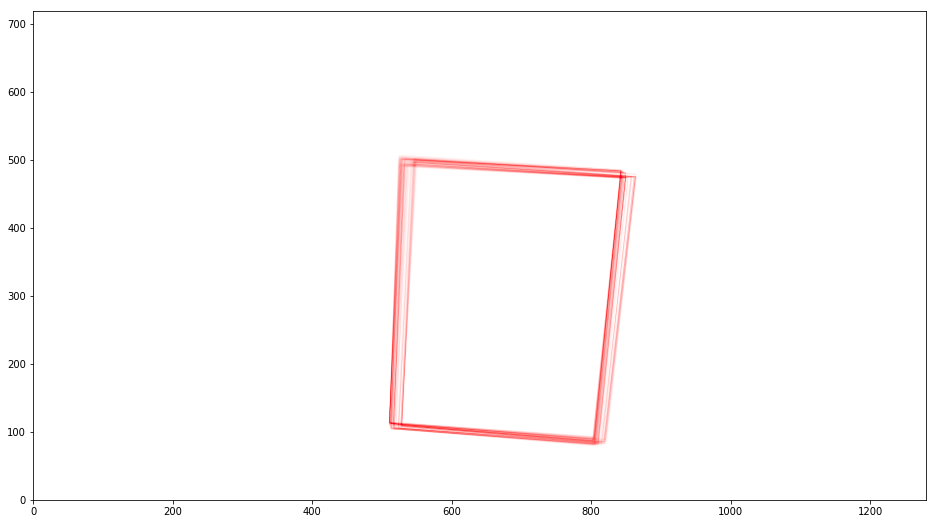

In [5]:
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

plt.figure(figsize = (16, 9))
axes = plt.gca()
axes.set_xlim([0., 1280.])
axes.set_ylim([0., 720.])

polygons = PolyCollection(surface_pd_frame['surface_position_screen'],
                         edgecolors=((1., 0,.2,.005),),
                         facecolors=((0,0,0,0),),
                         )
axes.add_collection(polygons)



plt.show()